In [61]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
# from helper import get_mi_score
%matplotlib inline

In [ ]:
plt.rcParams['axes.grid'] = True   # Default behaviour for all graphs. 

**Load data**

In [ ]:
telecom_data = pd.read_csv(r"C:\Users\kidus\synergyTelecom\data\WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col= "customerID")
telecom_data.Churn.value_counts()

*"Fix" the TotalCharges columns*

In [ ]:
# Customers with no tenure have an empty string as their TotalCharges. It should be replaced with the appropriate numerical value.
no_tenure = telecom_data[telecom_data.tenure == 0]   

total_charges_filled = telecom_data[telecom_data.index.isin(no_tenure.index)].copy()  # select from the original dataframe whose index is in the "no_tenure" dataframe.
total_charges_filled["TotalCharges"] = total_charges_filled["MonthlyCharges"] * total_charges_filled["tenure"]

telecom_data.update(total_charges_filled)
telecom_data["TotalCharges"] = telecom_data["TotalCharges"].astype(float)

**EDA**

*KDE to show the relationship between tenure and churn*

In [ ]:
plt.title("Kernel Density Estimate of tenure for Churned vs Unchurned customers")
plt.xlabel("Tenure (months)")
sns.kdeplot(data = telecom_data,  x = "tenure", hue = "Churn", fill = False)

*Illustrate the relationship between contract type and churn*

In [ ]:
plt.title("Contract type of churned and unchurned customers")
sns.countplot(data = telecom_data, x = "Contract", hue = "Churn")
telecom_data.Contract.value_counts()

*Monthly Charges for churned and unchurned customers*

In [ ]:
plt.xlabel("Monthly charges")
sns.kdeplot(data = telecom_data, x = "MonthlyCharges", hue = "Churn")

# The plot shows MonthlyCharge isn't, on its own, discriminative enough.  

<Axes: xlabel='Dependents', ylabel='count'>

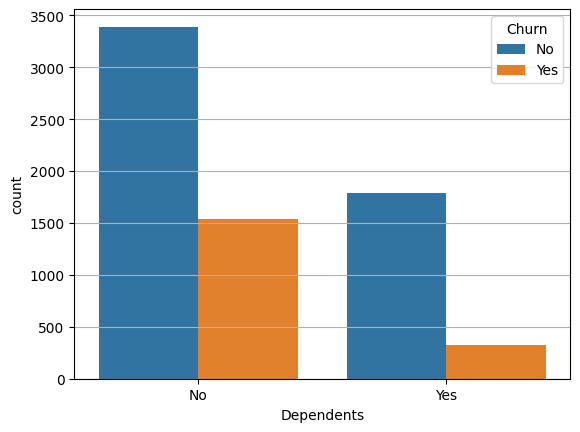

In [56]:
sns.countplot(data = telecom_data, x = "Dependents", hue = "Churn")

In [ ]:
y = telecom_data["Churn"].map({"Yes": 1, "No":0})

X = telecom_data.drop("Churn", axis = 1)
X["gender"] = X["gender"].map({"Male": 0, "Female": 1})      # Mapping the gender columns. 0 refers to Male and 1 refers to Female.

closed_columns = ["Partner", "Dependents", "PhoneService"]  # Binary columns with Yes or No values. 
for col in closed_columns:      # Encode the columns. 0 means No and 1 means Yes. 
    X[col] = X[col].map({"No": 0, "Yes": 1})


In [ ]:
# only_nums_X = X.select_dtypes(include= "number")
# num_features = only_nums_X.dtypes == float | int
# get_mi_score(only_nums_X, y, discrete_features= num_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 1)
X_train: pd.DataFrame
X_test: pd.DataFrame
y_train: pd.Series
y_test: pd.Series

*Select columns for encoding and encode appropriately*

In [ ]:
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_cols = X_train.select_dtypes(include= ["object", "category", "string"]).columns.to_list()

std_scaler = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown= "ignore")

preprocessor = ColumnTransformer(
                                    transformers= [
                                        ("numeric", std_scaler, numerical_cols), 
                                        ("categorical", categorical_transformer, categorical_cols)
                                        ])


*Define, fit and make predictions with the two specified model types.*

In [ ]:
logistic_model = LogisticRegression(random_state= 1)

logistic_pipeline = Pipeline(
                            steps = [("preprocess", preprocessor), 
                                        ("model", logistic_model)
                                        ])  

logistic_pipeline.fit(X_train, y_train)

logistic_proba = logistic_pipeline.predict_proba(X_test)[:, 1]   # Since we don't want to miss churners, we "increase" our recall at the cost of precision 
logistic_pred_adj = (logistic_proba >= 0.4).astype(int)

log_cm = pd.DataFrame(confusion_matrix(y_test, logistic_pred_adj), 
                      index = ["Actual Negative", "Actual Positive"], 
                      columns= ["Predicted Negative", "Predicted Positive"])

log_report = classification_report(y_test, logistic_pred_adj)
log_auc_score = roc_auc_score(y_test, logistic_pred_adj)


In [ ]:
xgb_model = XGBClassifier(random_state = 1)
xgb_pipeline = Pipeline(steps =[("preprocessor", preprocessor), 
                                                    ("model", xgb_model)
                                                    ])

xgb_pipeline.fit(X_train, y_train)
xgb_proba = xgb_pipeline.predict_proba(X_test)[:, 1]            # Since we don't want to miss churners, we "increase" our recall at the cost of precision
xgb_pred_adj = (xgb_proba >= 0.4).astype(int)

xgb_cm = pd.DataFrame(confusion_matrix(y_test, xgb_pred_adj), 
                      index = ["Actual Negative", "Actual Positive"], 
                      columns= ["Predicted Negative", "Predicted Positive"])

xgb_report = classification_report(y_test, xgb_pred_adj)
xgb_auc_score = roc_auc_score(y_test, xgb_pred_adj)


As the LogisticRegressor slightly outperforms the XGBClassifier, we shall use that for the upcoming tasks.  